In [104]:
import os
import csv
import pandas as pd
import datetime
import dateparser
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pytz import timezone

In [82]:
data_dir = '../../data/'

#### Define CSV iterator to read the data in its "segmented" format

In [83]:
class CSVIterator:
  def __init__(self, filename, data_start_mark, data_end_mark, stellwagen = False):
    self.stellwagen = stellwagen
    self.filename = filename
    self.twoDArray = self.csvToArr(filename)
    self.data_start_mark = data_start_mark
    self.data_end_mark = data_end_mark
    self.curr_ind = 0

  def csvToArr(self, filename):
    twoDArray = []
    with open(filename, newline='') as csvfile:
      data = csv.reader(csvfile, delimiter=',', quotechar='"')
      for row in data:
        twoDArray.append(row)
    return [arr if arr else [''] for arr in twoDArray]
  
  def hasNextData(self):
    return self.curr_ind < len(self.twoDArray) and self.data_start_mark in [arr[0] for arr in self.twoDArray[self.curr_ind:]]
    
  def getNextData(self):
    if not self.hasNextData():
      raise Exception('No data left')
    
    # Move to the column row
    while self.twoDArray[self.curr_ind][0] != self.data_start_mark:
      self.curr_ind += 1

    if self.stellwagen:
      self.curr_ind += 1
      
    columns = self.twoDArray[self.curr_ind]

    # Move to the start of the data
    self.curr_ind += 1
    
    data_start_ind = self.curr_ind

    while self.curr_ind < len(self.twoDArray) and self.twoDArray[self.curr_ind][0] != self.data_end_mark:
      self.curr_ind += 1

    data = self.twoDArray[data_start_ind:self.curr_ind]

    try:
      return pd.DataFrame(data, columns = columns)
    except:
      raise Exception(f'Error parsing {self.filename}')

In [84]:
def get_all_data(csv_it):
  chunks = []
  while csv_it.hasNextData():
    next_data = csv_it.getNextData()
    chunks.append(next_data)
  try:
    all_data = pd.concat(chunks, ignore_index=True)
  except:
    raise Exception(f'Error concatenating {csv_it.filename}')
  return all_data

#### Read Sensor Data

In [107]:
start = 'DATE'
end = 'Eureka_Manta_2'
csvs = []

for file in os.listdir(data_dir + 'Stellwagen_Bank_NMS/'):
    if file.endswith(".csv"):
      if file.split('.')[0].split('_')[-1] == 'SBNMS':
        filename = data_dir + 'Stellwagen_Bank_NMS/' + file

        it = CSVIterator(filename, start, end)

        all_data = get_all_data(it)

        csvs.append(all_data)
      
sensor_data = pd.concat(csvs, ignore_index=True)

#### Clean the sensor data

In [108]:
# Discard Spec Conductance less than or equal to 20000
sensor_data['SpCond_uS/cm'] = sensor_data['SpCond_uS/cm'].astype(float)
sensor_data = sensor_data[sensor_data['SpCond_uS/cm'] > 20000]

# Parse date strings to datetime
sensor_data['Timestamp'] = [dateparser.parse(row['DATE'] + " " +  row['TIME']) for _, row in sensor_data.iterrows()]

# Set the timezone to eastern
sensor_data['Timestamp'] = sensor_data['Timestamp'].dt.tz_localize(timezone('US/Eastern'))

# Sort by timestamp
sensor_data.sort_values(by='Timestamp', inplace=True)

# Create bin columns
sensor_data['Y-m-d-H-M'] = [datetime.datetime.strftime(date, "%Y-%m-%d-%H-%M") for date in sensor_data['Timestamp']]
sensor_data['Y-m-d'] = [datetime.datetime.strftime(date, "%Y-%m-%d") for date in sensor_data['Timestamp']]

/Users/becklabash/Library/Python/3.8/lib/python/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


#### Read telemetry data (lat, lon, ele)

In [109]:
start = 'trkpt'
end = ''
csvs = []

for file in os.listdir(data_dir + 'Stellwagen_Bank_NMS/'):
    if file.endswith(".csv"):
      if len(file.split('_')) == 3:
        filename = data_dir + 'Stellwagen_Bank_NMS/' + file
        it = CSVIterator(filename, start, end, stellwagen = True)
        all_data = get_all_data(it)
        csvs.append(all_data)
telemetry_data = pd.concat(csvs, ignore_index=True)

#### Clean the telemetry data

In [110]:
# Parse date strings to datetime
telemetry_data['Timestamp'] = [datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ") for date in telemetry_data['time']]

# Set the timezone to UTC then convert to Eastern time
telemetry_data['Timestamp'] = [date.replace(tzinfo=timezone('UTC')).astimezone(timezone('US/Eastern')) for date in telemetry_data['Timestamp']]

# Create bin columns
telemetry_data['Y-m-d-H-M'] = [datetime.datetime.strftime(date, "%Y-%m-%d-%H-%M") for date in telemetry_data['Timestamp']]
telemetry_data['Y-m-d'] = [datetime.datetime.strftime(date, "%Y-%m-%d") for date in telemetry_data['Timestamp']]

#### Match telemetry to the sensor data using time

In [112]:
for ind, row in tqdm(sensor_data.iterrows()):
  time_bin = row['Y-m-d-H-M']
  time = row['Timestamp']
  potential_matches = telemetry_data[telemetry_data['Y-m-d-H-M'] == time_bin]
  for match_ind, match in potential_matches.iterrows():
    if abs(match['Timestamp'] - time) < datetime.timedelta(seconds=2):
      sensor_data.loc[ind, 'lat'] = match['lat']
      sensor_data.loc[ind, 'lon'] = match['lon']
      sensor_data.loc[ind, 'ele'] = match['ele']
      break
print(f'Matched {len(sensor_data[sensor_data["lat"].notnull()])} out of {len(sensor_data)} points')

1672it [00:07, 210.53it/s]

Matched 756 out of 1672 points


#### Clean the data and export

In [56]:
sensor_data[sensor_data['lat'].notnull()].to_csv(data_dir + 'Stellwagen_Bank_NMS/concat/2019_SBNMS.csv', index=False)

In [94]:
set(telemetry_data['Y-m-d'].unique()).intersection(set(sensor_data['Y-m-d'].unique()))

{'2019-02-23',
 '2019-03-19',
 '2019-04-12',
 '2019-04-17',
 '2019-04-25',
 '2019-04-29',
 '2019-04-30'}

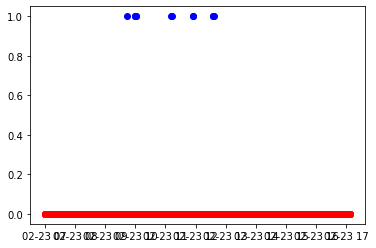

In [113]:
sensor_feb_23 = sensor_data[sensor_data['Y-m-d'] == '2019-02-23']
telem_feb_23 = telemetry_data[telemetry_data['Y-m-d'] == '2019-02-23']
# Plot the timestamps of the sensor data and the telemetry data on the same plot
plt.plot(sensor_feb_23['Timestamp'], np.ones(len(sensor_feb_23)), 'bo')
plt.plot(telem_feb_23['Timestamp'], np.zeros(len(telem_feb_23)), 'ro')